In [4]:
import pandas as pd
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
import numpy as np

In [5]:
similarities = pd.read_csv("chatgpt_similarities.csv")

In [6]:
sims = similarities.pivot(index="Rock1", columns="Rock2", values="ChatGPT Rating").fillna(0).to_numpy()
sims = np.pad(sims, pad_width=((0, 1), (1, 0)), mode='constant', constant_values=0)
sims += np.eye(30, 30) * 9
for i in range(30):
    for j in range(i+1, 30):
        sims[j, i] = sims[i, j]
dissims = 9 - sims

In [7]:
mds = MDS(n_components=8, metric=False, n_init=10, dissimilarity='precomputed', normalized_stress=True)
mds_solution = mds.fit_transform(dissims)

In [8]:
mds.stress_

0.1296100123182679

In [9]:
ratings = pd.read_csv("chatgpt_ratings.csv")
ratings = ratings.pivot(index="Rock", columns="Dimension", values="ChatGPT Rating").to_numpy()
ratings = np.pad(ratings, pad_width=((0, 0), (0, 2)), mode='constant', constant_values=0)


In [10]:
mtx1 = np.array(ratings, dtype=np.float64, copy=True)
mtx2 = np.array(mds_solution, dtype=np.float64, copy=True)

# translate all the data to the origin
mtx1 -= np.mean(mtx1, 0)
mtx2 -= np.mean(mtx2, 0)

norm1 = np.linalg.norm(mtx1)
norm2 = np.linalg.norm(mtx2)

# change scaling of data (in rows) such that trace(mtx*mtx') = 1
mtx1 /= norm1
mtx2 /= norm2

# transform mtx2 to minimize disparity
R, s = orthogonal_procrustes(mtx1, mtx2)
mtx2 = np.dot(mtx2, R.T)

mtx2 *= norm2

In [20]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

def plot_images(img_dir, x, y, xlabel, ylabel,
                img_scale=.2, fig_size=36, file_format='.png', correlate=False, save_file=None):
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(1,1,1)
    for subdir, dirs, files in os.walk(img_dir):
        dirs.sort()
        sorted_files = sorted(filter(lambda f: f.endswith(file_format), files))
        for i, file in enumerate(sorted_files):
            if file.endswith(file_format):
                image = plt.imread(os.path.join(subdir, file))
                im = OffsetImage(image, zoom=img_scale)
                x0 = x[i]
                y0 = y[i]
                artists = []
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
                artists.append(ax.add_artist(ab))
                ax.update_datalim(np.column_stack([x0, y0]))
                ax.autoscale()
    for spine in ax.spines.values():
        spine.set_visible(False)
    if correlate:
        plt.plot(plt.ylim(), plt.ylim(), color='black', linestyle='--', linewidth=4)
        corr = np.corrcoef(x, y)[0,1]
        ax.annotate('r = {}'.format(round(corr, 2)), xy=(max(x), min(y)), size=50)
    plt.xlabel(xlabel, fontsize=fig_size)
    plt.ylabel(ylabel, fontsize=fig_size)
    plt.tick_params(labelsize=fig_size/2)
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()
    plt.close()

In [12]:
rocks_path = "data\\Rocks Library\\30 Rocks"
figs_path = "figures\\"

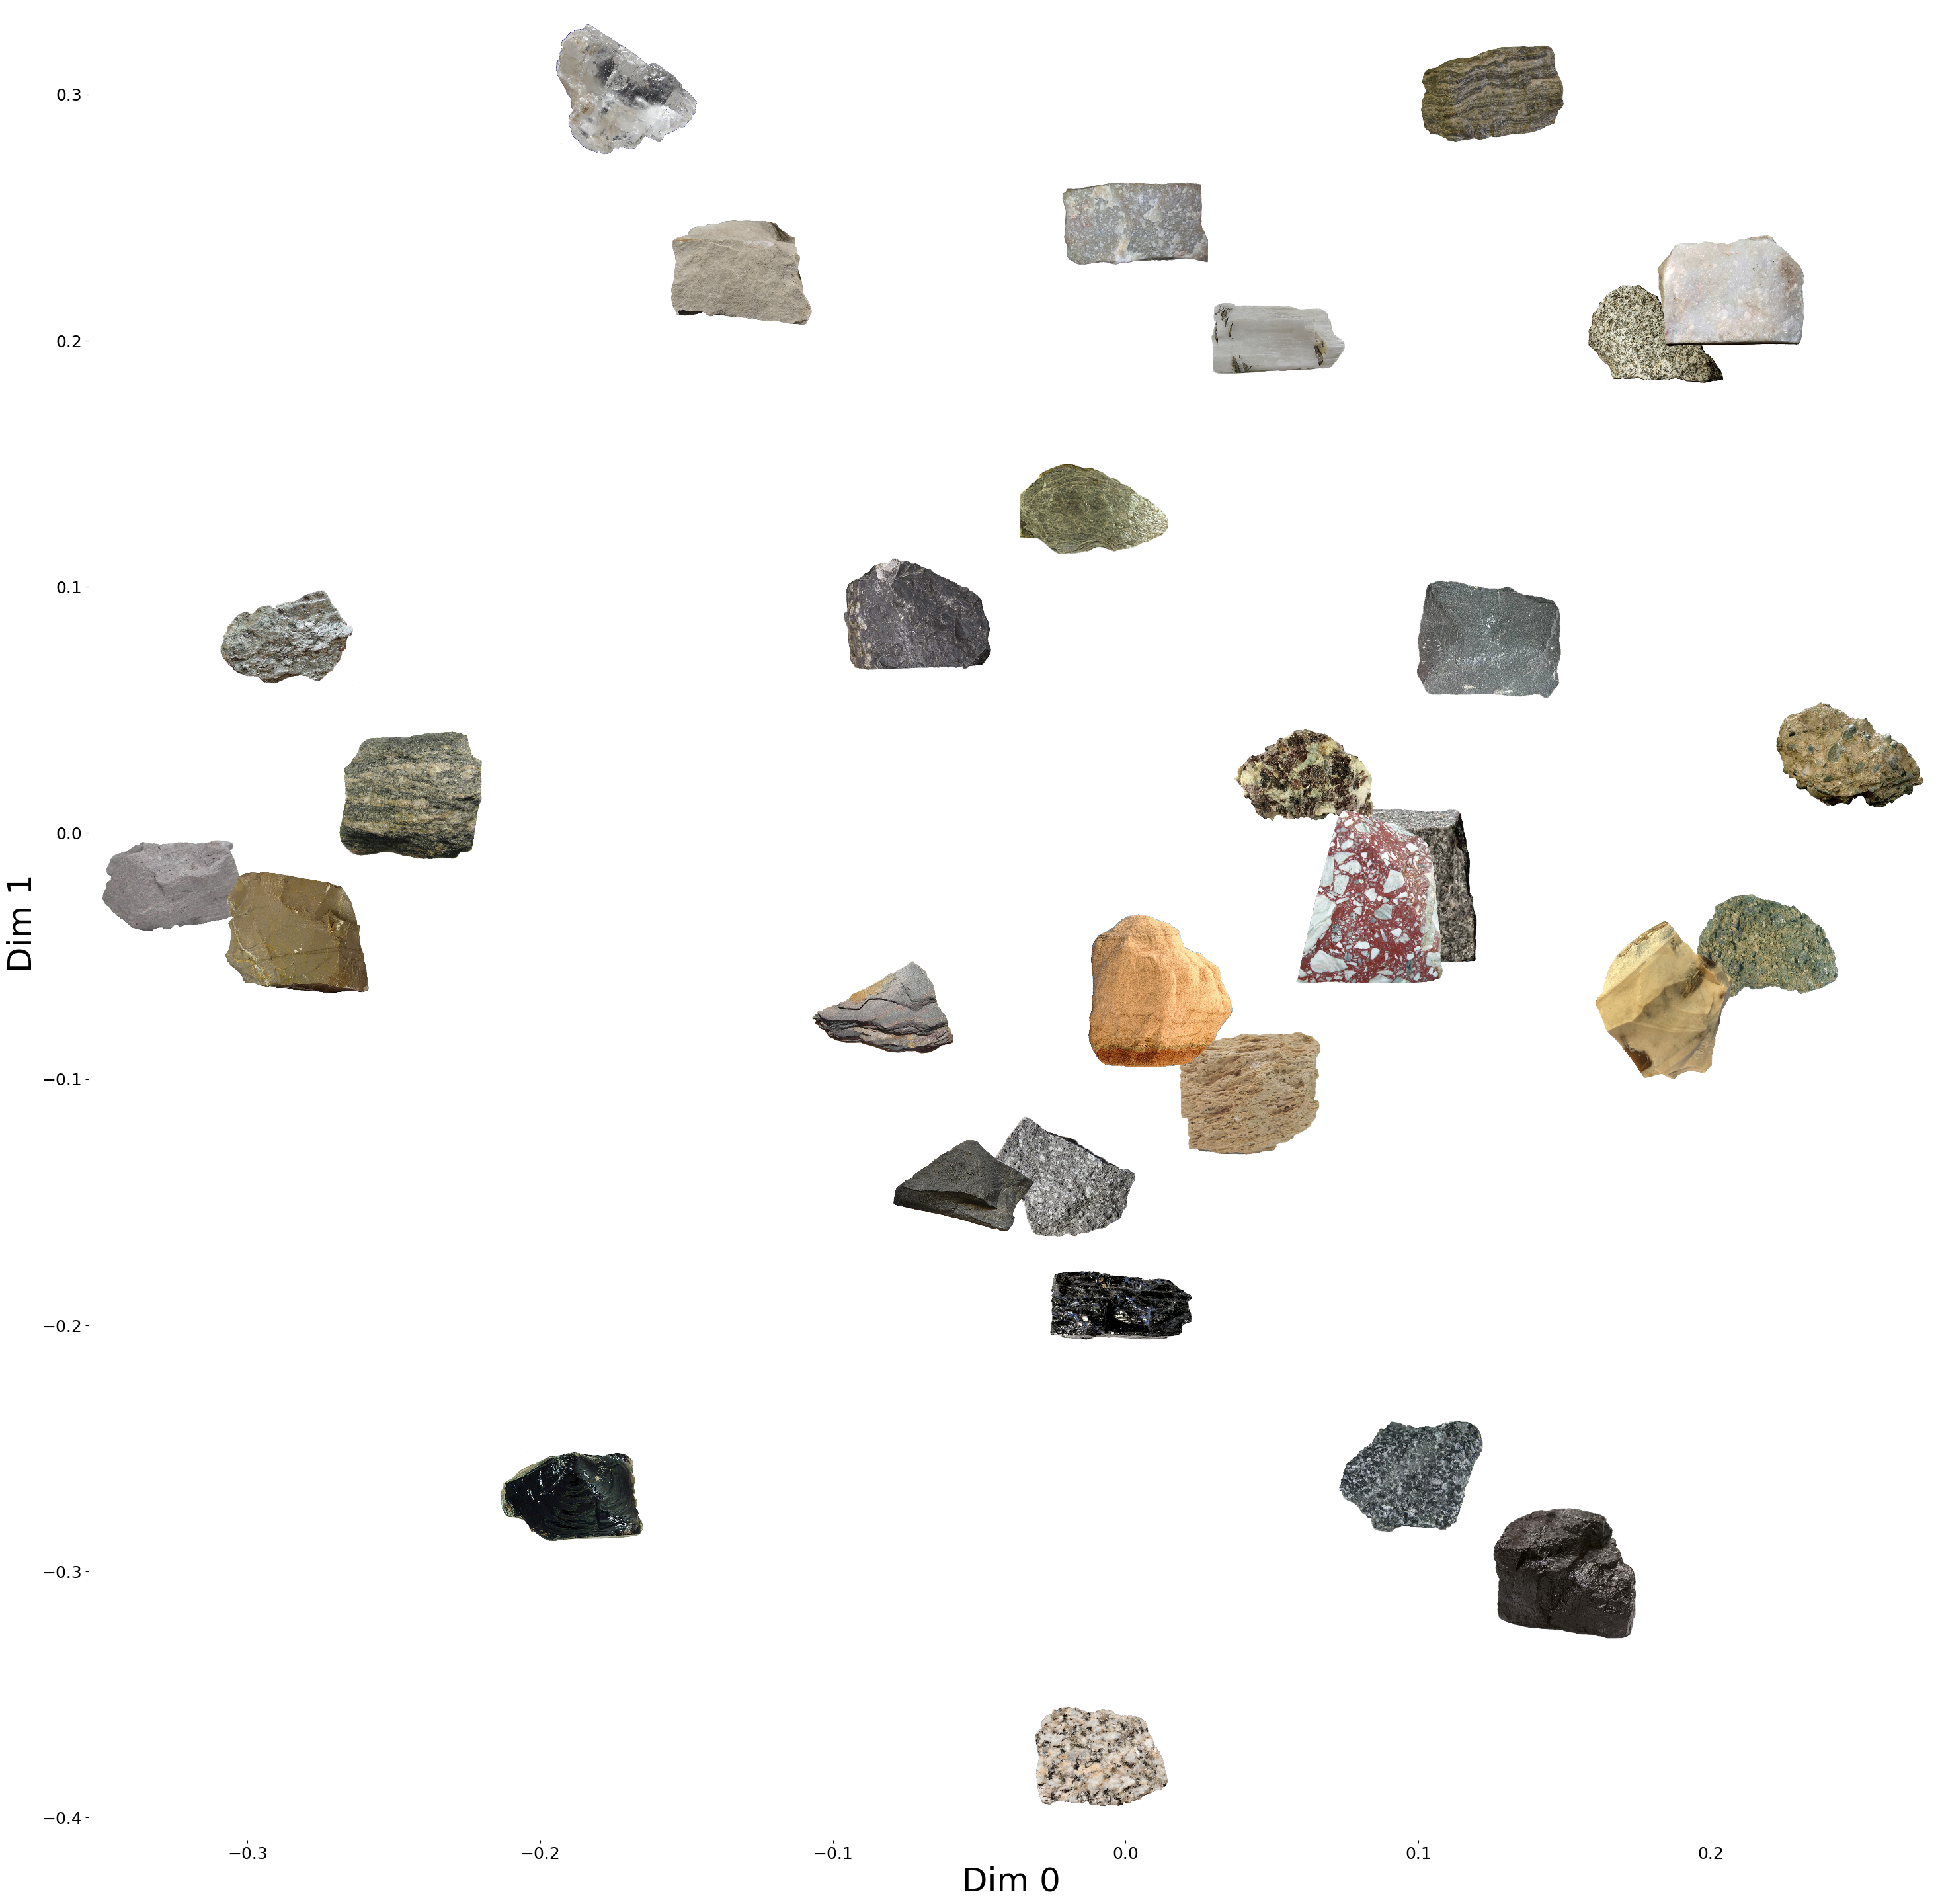

In [21]:
i=0
plot_images(rocks_path, mtx2[:,i], mtx2[:,i+1], f"Dim {i}", f"Dim {i+1}", save_file=f"mds{i}x{i+1}.png")

In [19]:
for i in range(6):
    print(np.corrcoef(mtx2[:,i], ratings[:,i])[0,1])

0.3993136924646555
0.5280114917236853
0.43935507902509335
0.5389331959614062
0.6265064787046167
0.2530446787342123
